## Stock Return Prediction

In this case study we will use various supervised learning-based models to predict the
stock price of Microsoft using correlated assets and its own historical data.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)    
    * [4.2.Feature Selection](#3.2) 
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
        * [5.3.1 Machine Learning models-scikit-learn](#4.3.1)
        * [5.3.2 Time Series based Models-ARIMA; LSTM and FBprophet ](#4.3.2)
* [6. Model Tuning and grid search](#5)
* [7. Finalise the model](#6)
    * [7.1. Result on the test dataset](#6.1)
    * [7.2. Save Model for Later Use](#6.2)     

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, weekly return of the
Microsoft stock is the predicted variable. We need to understand what affects Microsoft stock price and hence incorporate as much information into the model. 

For this case study, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
from prophet import Prophet

#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


C:\Users\ngocb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

Next, we extract the data required for our analysis using pandas datareader. 

In [3]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']  
#U.S. / U.K. Foreign Exchange Rate (DEXUSUK) 
#Japanese Yen to U.S. Dollar Spot Exchange Rate (DEXJPUS)
idx_tickers = ['SP500', 'DJIA', 'VIXCLS'] 
# The S&P 500 index, or Standard & Poor's 500, is a very important index that tracks the performance 
# of the stocks of 500 large-cap companies in the U.S
# The Dow Jones Industrial Average, Dow Jones, or simply the Dow, 
# is a stock market index of 30 prominent companies listed on stock exchanges in the United States.
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')
stk_data = yf.download(tickers = stk_tickers, start = '2019-01-01', end = '2023-05-01')

[*********************100%***********************]  3 of 3 completed


Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

In [4]:
return_period = 5

We now define our Y series and our X series

Y: MSFT **Future** Returns

X:

    a. GOOGL 5 Business Day Returns
    b. IBM 5 Business DayReturns    
    c. USD/JPY 5 Business DayReturns    
    d. GBP/USD 5 Business DayReturns    
    e. S&P 500 5 Business DayReturns    
    f. Dow Jones 5 Business DayReturns    
    g. MSFT 5 Business Day Returns    
    h. MSFT 15 Business Day Returns    
    i. MSFT 30 Business Day Returns    
    j. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models.

In [5]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

Lets have a look at the dataset we have

In [6]:
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,0.004679,0.002143,0.002002,0.001169,-0.000754,0.002125,0.001654,-0.001405,0.004760,0.013241,0.026711,0.055642
std,0.037536,0.040922,0.039834,0.012784,0.014092,0.029820,0.030534,0.154378,0.035330,0.065530,0.081113,0.105455
min,-0.137317,-0.131259,-0.173146,-0.052258,-0.066158,-0.140676,-0.166713,-0.365991,-0.137317,-0.239569,-0.299102,-0.245550
25%,-0.017125,-0.022730,-0.015367,-0.004698,-0.007784,-0.011826,-0.010676,-0.097571,-0.014520,-0.019818,-0.026287,-0.006134
50%,0.006455,0.006346,0.004481,0.001071,-0.000977,0.005384,0.003130,-0.023990,0.007681,0.020446,0.036575,0.071149
75%,0.026594,0.025101,0.022292,0.007798,0.006603,0.017264,0.016282,0.073934,0.025678,0.049721,0.084661,0.135304
max,0.164102,0.110223,0.175315,0.052731,0.075400,0.160395,0.183091,0.650554,0.164102,0.244822,0.207463,0.293344


In [7]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2019-03-29,0.016399,-0.025801,0.011763,0.008347,-0.014247,0.011957,0.016580,-0.184022,0.007575,0.065070,0.102544,0.158130
2019-04-05,0.008802,0.028943,0.015332,0.009263,-0.001690,0.020374,0.018960,-0.067119,0.016399,0.033761,0.077315,0.143853
2019-04-12,0.022967,0.009268,0.007440,0.002593,0.005825,0.005059,-0.000480,-0.065267,0.008802,0.032776,0.072157,0.142066
2019-04-22,0.047419,0.025061,-0.038559,-0.000536,-0.009353,0.000822,0.004775,0.008084,0.022967,0.048168,0.113238,0.157282
2019-04-30,-0.039674,-0.058027,-0.001211,-0.004121,0.006699,0.004133,-0.002384,0.066166,0.040312,0.085231,0.105105,0.243810


<a id='2.2'></a>
## 3.2. Data Visualization

Next, lets look at the distribution of the data over the entire period

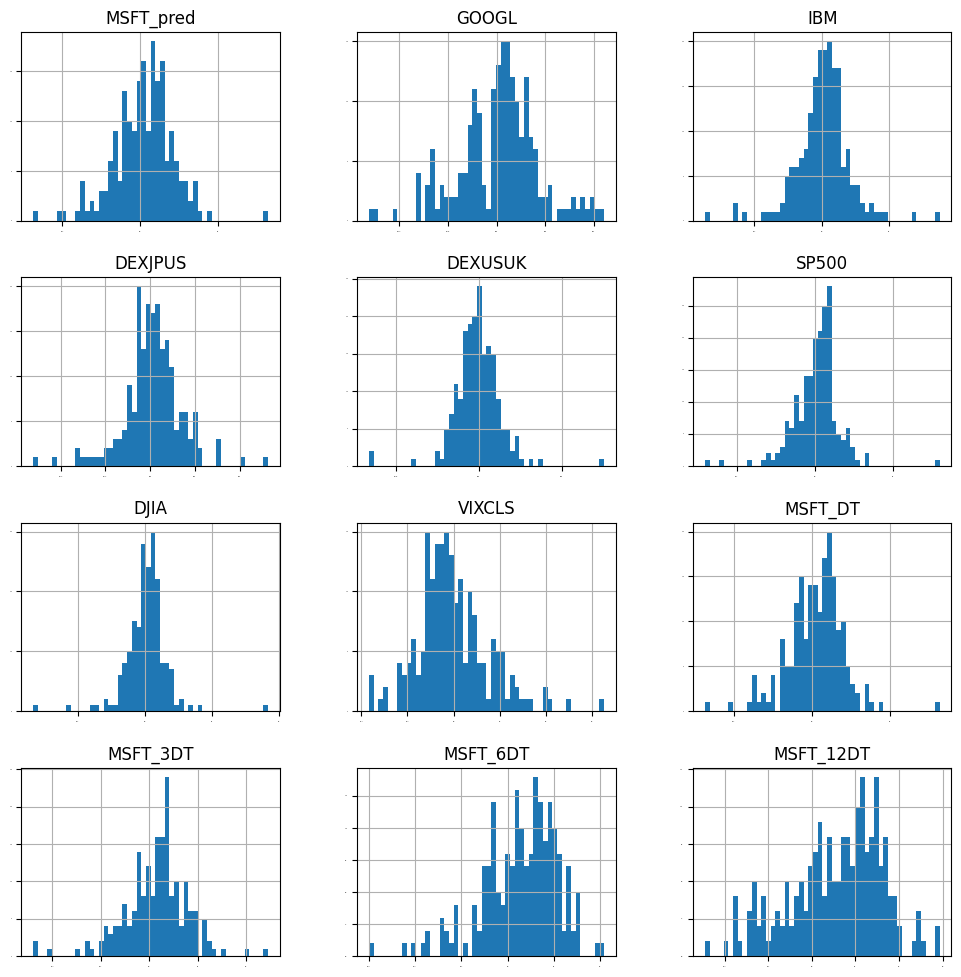

In [8]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

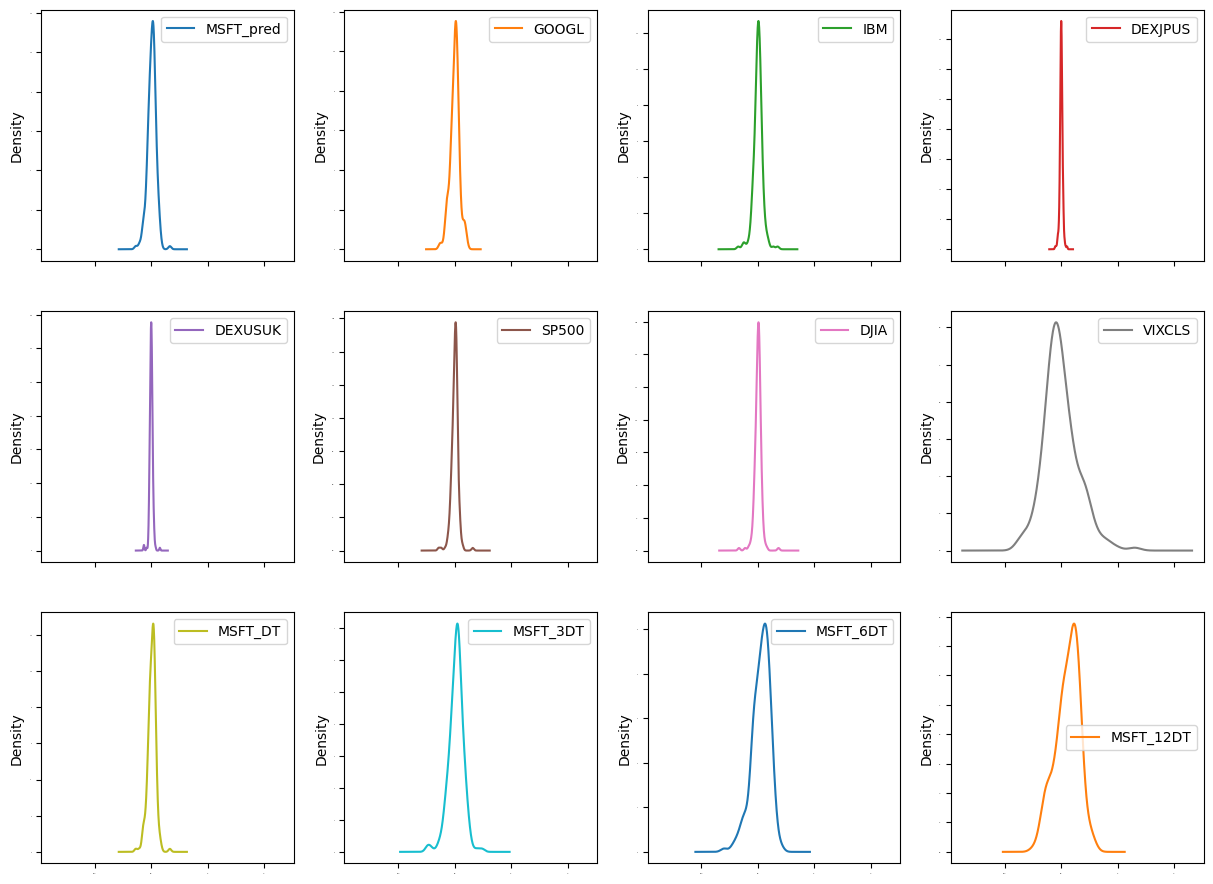

In [9]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

<AxesSubplot: title={'center': 'Correlation Matrix'}>

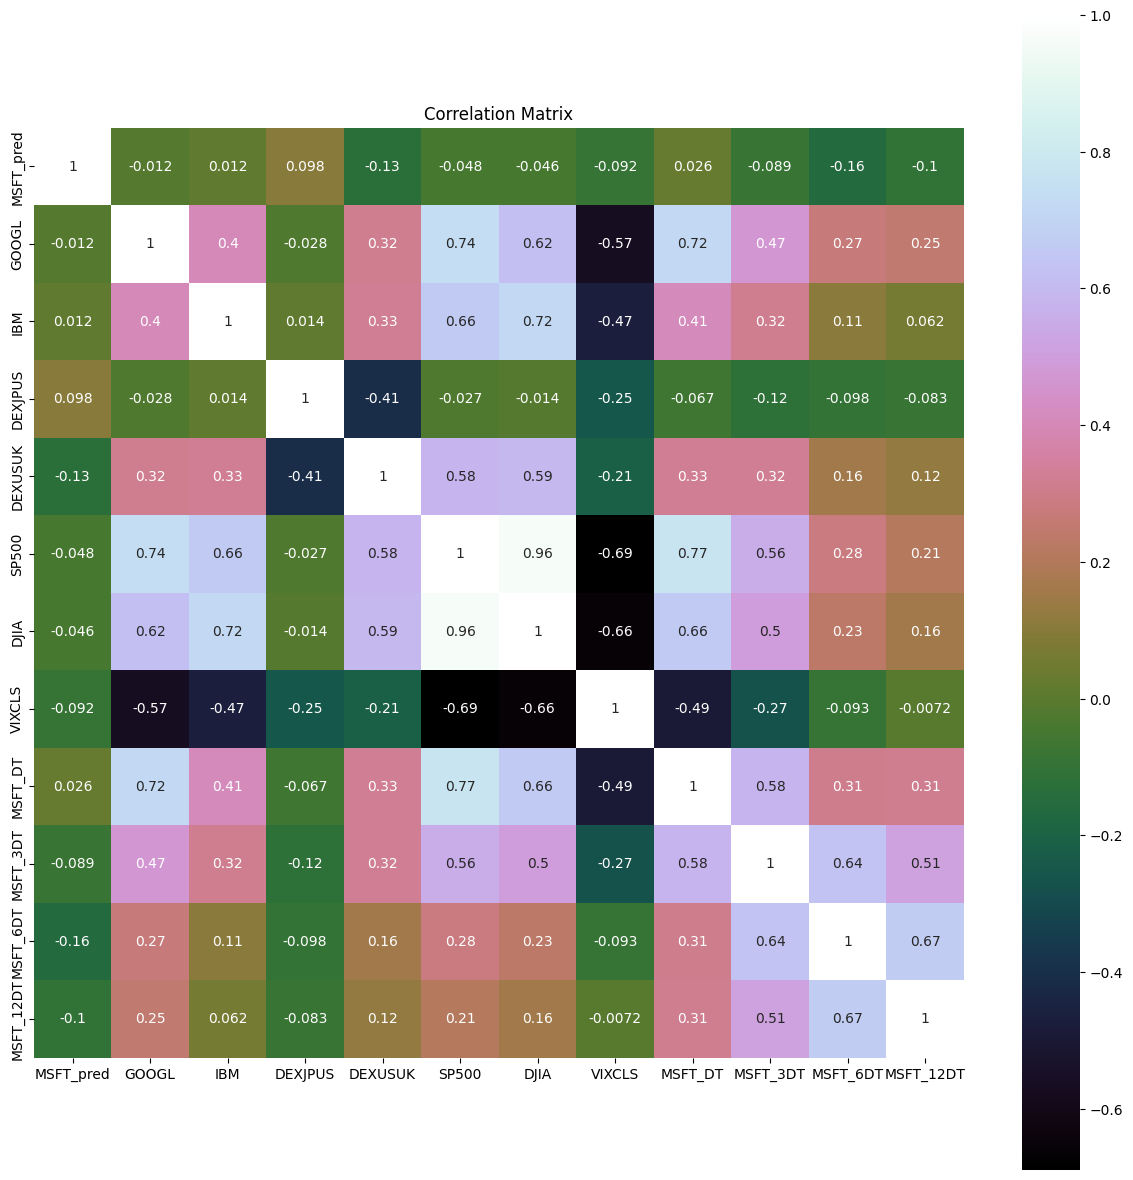

In [10]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Looking at the correlation plot above, we see some correlation of the predicted vari‐
able with the lagged 5 days, 15days, 30 days and 60 days return of MSFT. 

<Figure size 1500x1500 with 0 Axes>

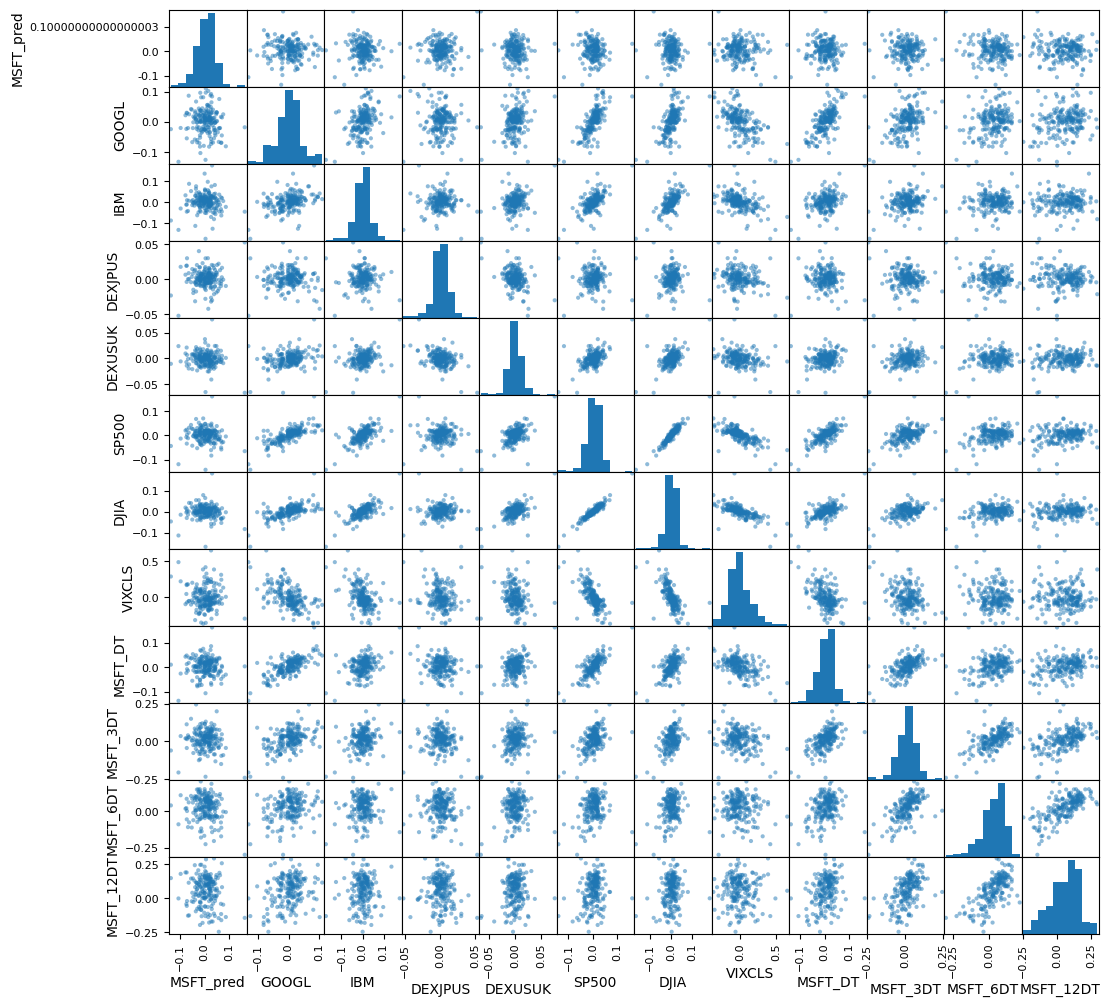

In [11]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

Looking at the scatter plot above, we see some linear relationship of the predicted
variable the lagged 15 days, 30 days and 60 days return of MSFT.

<a id='2.3'></a>
## 3.3. Time Series Analysis 

Next, we look at the seasonal decomposition of our time series

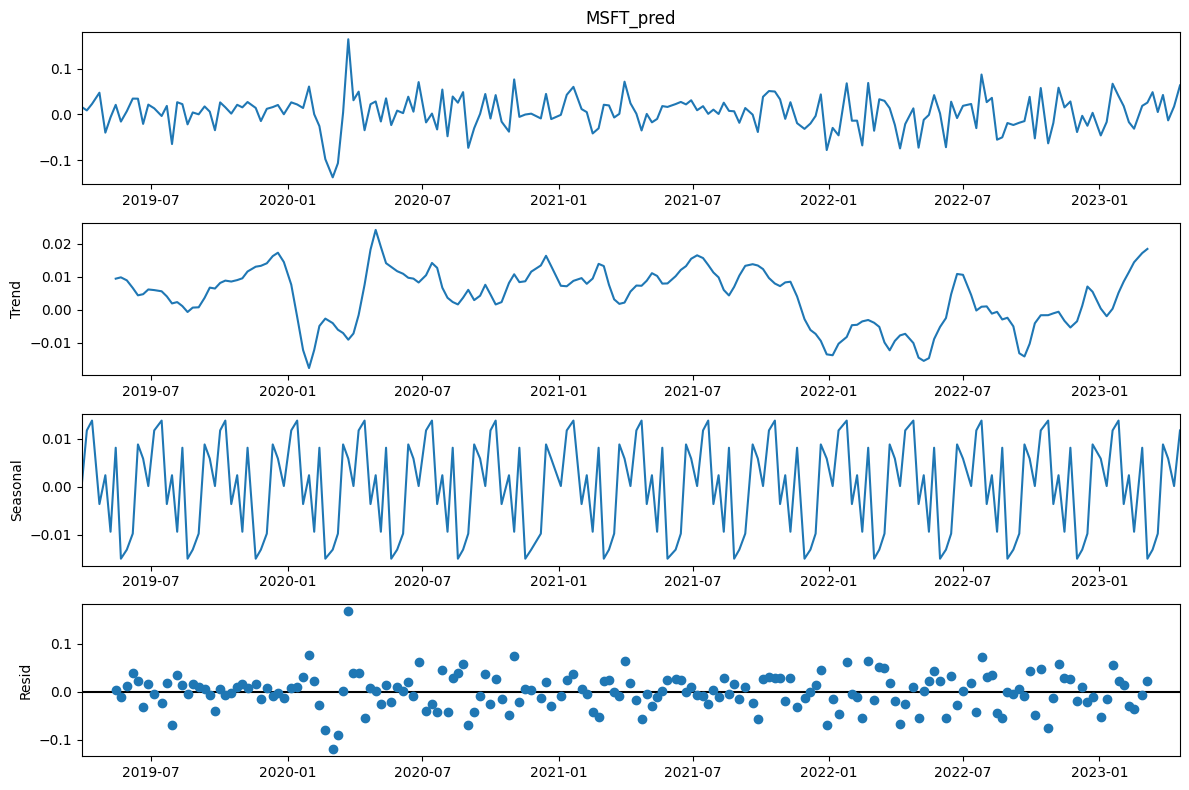

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose 
from matplotlib import pyplot as plt
decompose_result = seasonal_decompose(Y.dropna(), period=12) 
df_trend = decompose_result.trend 
df_season = decompose_result.seasonal 
df_residual = decompose_result.resid 
plt.rcParams['figure.figsize'] = (12, 8) 
fig = decompose_result.plot()

In [13]:
# res = sm.tsa.seasonal_decompose(Y, extrapolate_trend='freq', period=365)
# fig = res.plot()
# fig.set_figheight(8)
# fig.set_figwidth(15)
# pyplot.show()

<a id='3'></a>
## 4. Data Preparation

<a id='3.2'></a>
## 4.2. Feature Selection

We use sklearn's SelectKBest function to get a sense of feature importance. 

In [14]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_6DT,4.913847
DEXUSUK,3.485717
MSFT_12DT,2.037983
DEXJPUS,1.875658
VIXCLS,1.622885
MSFT_3DT,1.520644
SP500,0.449354
DJIA,0.407904
MSFT_DT,0.131373


We see that IBM seems to be the most important feature and vix being the least important.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

Next, we start by splitting our data in training and testing chunks. If we are going to use Time series models we have to split the data in continous series.

In [15]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics

In [16]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1 Machine Learning models-from scikit-learn

##### Regression and Tree Regression algorithms

In [17]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))


##### Neural Network algorithms

In [18]:
models.append(('MLP', MLPRegressor()))

##### Ensable Models

In [19]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. First we run the K-fold analysis. Next we run the model on the entire training and testing dataset.

In [20]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001623 (0.000689) 0.001245 0.001665
LASSO: 0.001418 (0.000672) 0.001397 0.001420
EN: 0.001418 (0.000672) 0.001397 0.001420
KNN: 0.001690 (0.000737) 0.001200 0.001507
CART: 0.002985 (0.001266) 0.000000 0.003408
SVR: 0.001699 (0.001102) 0.001293 0.001419
MLP: 0.002153 (0.001139) 0.003111 0.003454
ABR: 0.001627 (0.000881) 0.000609 0.001476
GBR: 0.001994 (0.001100) 0.000059 0.001897
RFR: 0.001717 (0.000871) 0.000228 0.001551
ETR: 0.001736 (0.000883) 0.000000 0.001650


#### K Fold results

We being by looking at the K Fold results

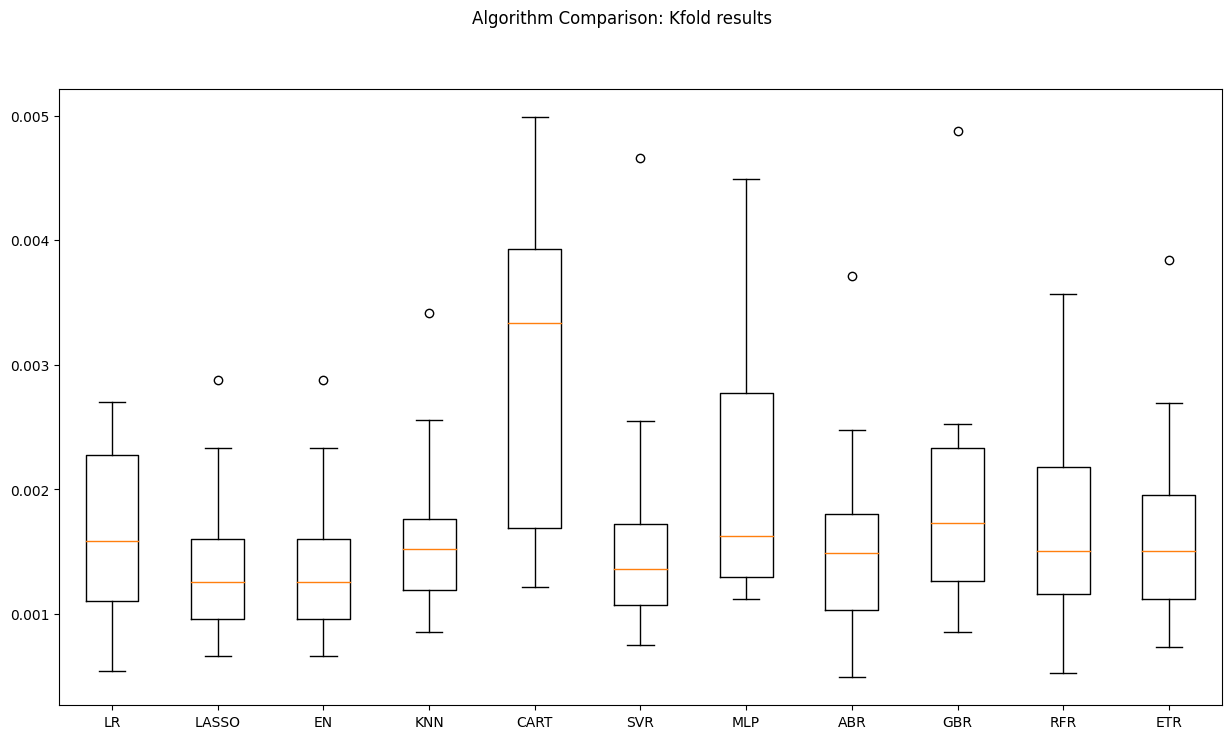

In [21]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

We see the linear regression and the regularized regression including the Lasso regression (LASSO) and elastic net (EN) seem to do a good job.

#### Training and Test error

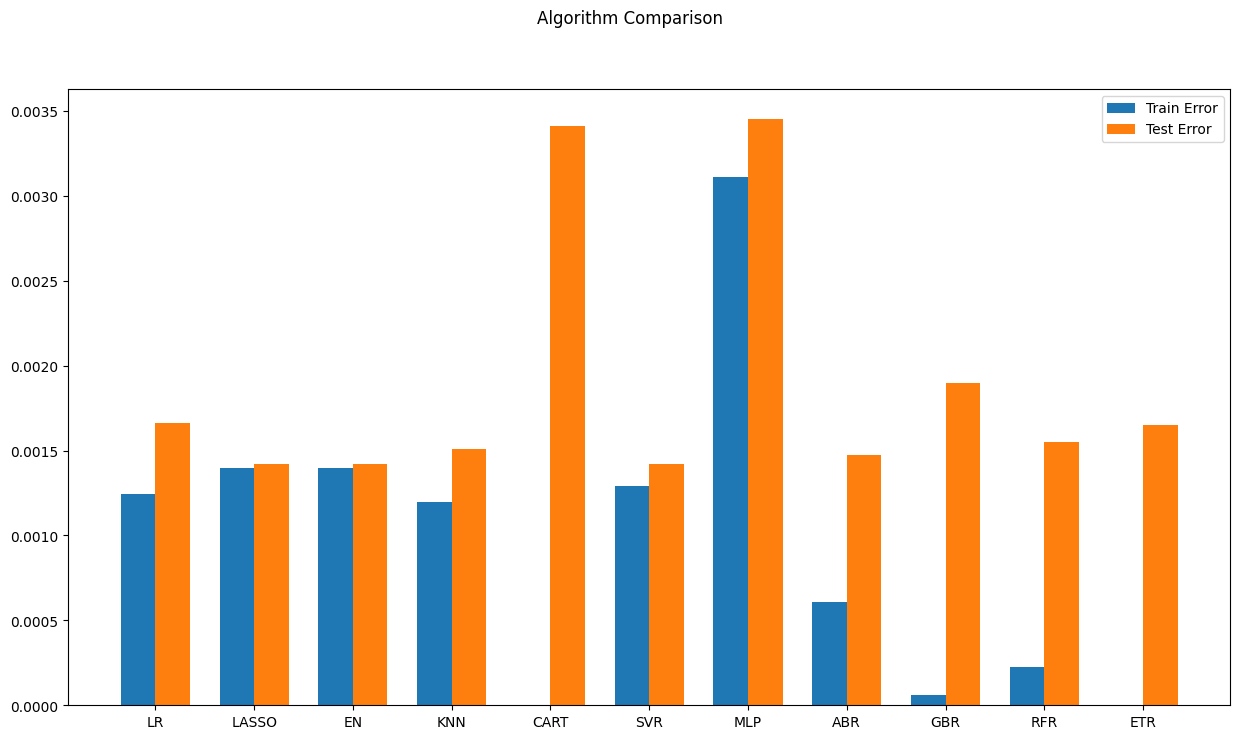

In [22]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()



Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on
the training data and produced very high error on the test set and these models
should be avoided. Ensemble models, such as gradient boosting regression (GBR) and
random forest regression (RFR) have low bias but high variance. We also see that the
artificial neural network (shown as MLP is the chart) algorithm shows higher errors
both in training set and test set, which is perhaps due to the linear relationship of the
variables not captured accurately by ANN or improper hyperparameters or insuffi‐
cient training of the model.

<a id='4.3.1'></a>
### 5.3.1 Time Series based models-ARIMA and LSTM

Let us first prepare the dataset for ARIMA models,
by having only the correlated varriables as exogenous variables.

### Time Series Model - ARIMA Model

In [23]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [24]:
from statsmodels.tsa.arima.model import ARIMA
modelARIMA= ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [25]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0014653483510809514

In [27]:
from prophet import Prophet
Y_train_prophet = pd.DataFrame({'ds':Y_train.index, 'y':Y_train.values})
Y_test_prophet = pd.DataFrame({'ds':Y_test.index, 'y':Y_test.values})
model = Prophet()
model.fit(Y_train_prophet)
forecast = model.predict(Y_train_prophet)
# import ml_metrics as metrics
import sklearn.metrics
metric_df = forecast.set_index('ds')[['yhat']].join(Y_train_prophet.set_index('ds').y).reset_index()
train_error_prophet = mean_squared_error(metric_df.y, metric_df.yhat)

05:16:22 - cmdstanpy - INFO - Chain [1] start processing
05:16:22 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
train_error_prophet

0.0011210389883603011

In [29]:
# model = Prophet()
# model.fit(Y_test_prophet)
forecast2 = model.predict(Y_test_prophet)
metric_df = forecast2.set_index('ds')[['yhat']].join(Y_test_prophet.set_index('ds').y).reset_index()
test_error_prophet = mean_squared_error(metric_df.y, metric_df.yhat)

05:16:23 - cmdstanpy - INFO - Chain [1] start processing
05:16:23 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
test_error_prophet

0.001379467620002871

###  LSTM Model

In [31]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]


In [32]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

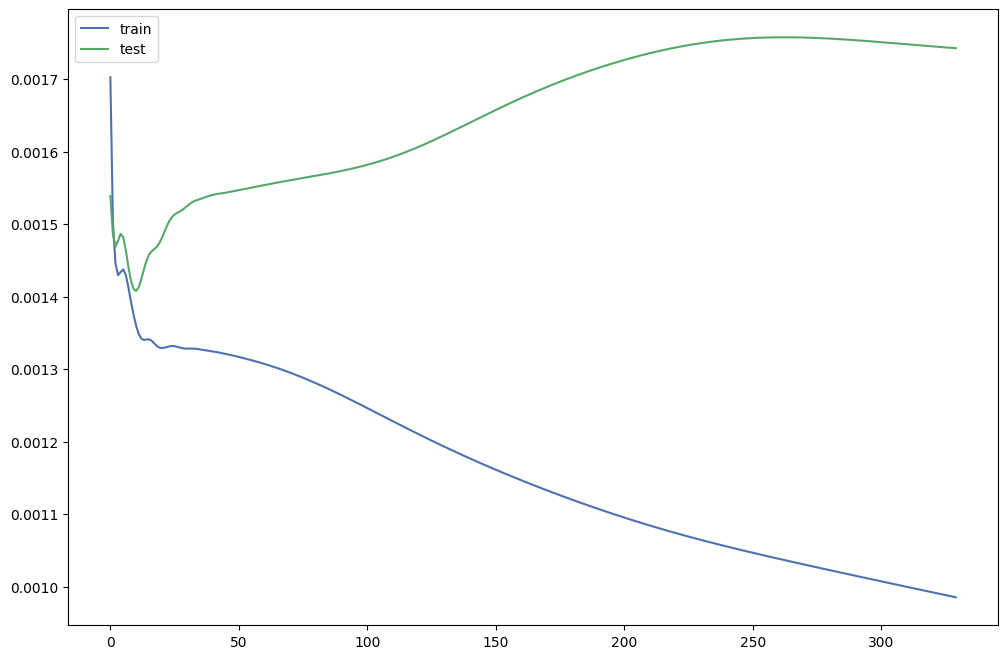

In [33]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [34]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

2/2 [==============================] - 0s 15ms/step


#### Append to previous results

In [35]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)
test_results.append(test_error_prophet)
train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)
train_results.append(train_error_prophet)

names.append("ARIMA")
names.append("LSTM")
names.append("prophet")

## Overall Comparison of all the algorithms ( including Time Series Algorithms)

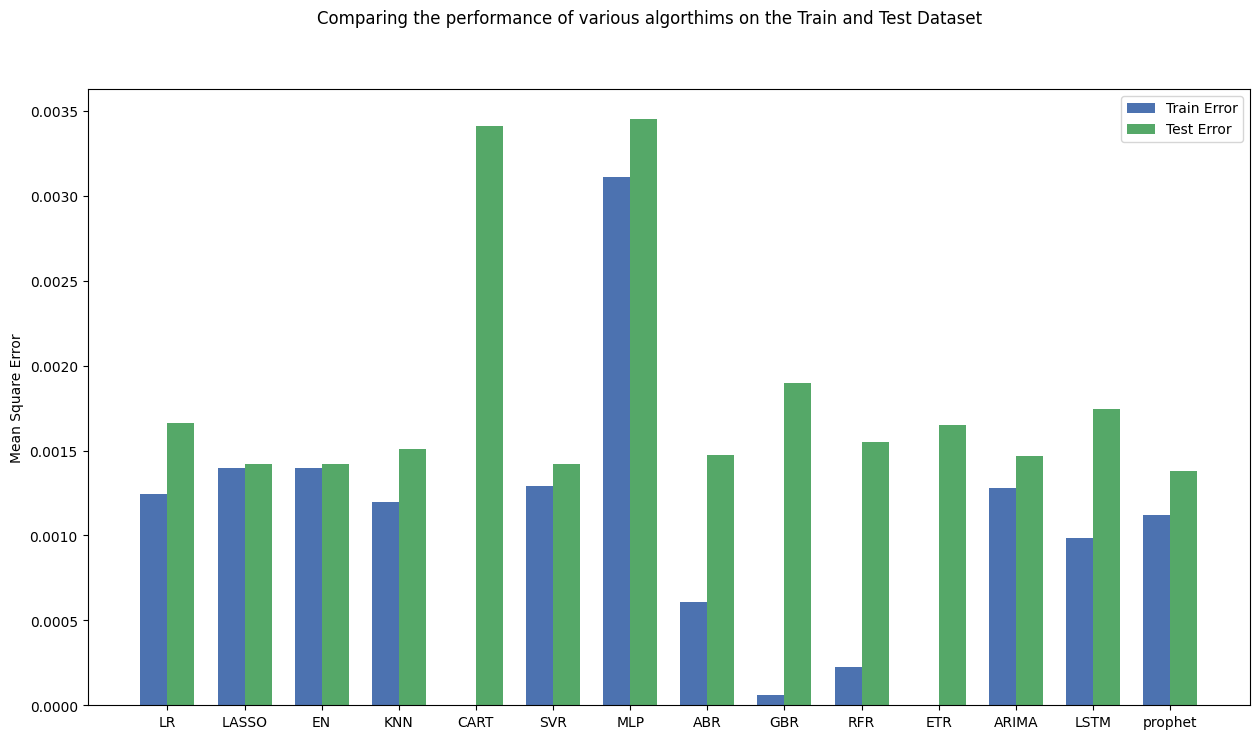

In [36]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

Looking at the chart above, we find time series based ARIMA model comparable to
the linear supervised-regression models such as Linear Regression (LR), Lasso Regres‐
sion (LASSO) and Elastic Net (EN). This can primarily be due to the strong linear
relationship as discussed before. The LSTM model performs decently, however,
ARIMA model outperforms the LSTM model in the test set. Hence, we can select the
ARIMA or prophet model for the model tuning.

<a id='5'></a>
# 6. Model Tuning and Grid Search

As shown in the chart above the ARIMA model is one of the best mode, so we perform the model tuning of the ARIMA model. The default order of ARIMA model is [1,0,0]. We perform a grid search with different combination p,d and q in the ARIMA model's order.  

In [37]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

ARIMA(0, 0, 0) MSE=0.0013320
ARIMA(0, 0, 1) MSE=0.0012907
ARIMA(0, 1, 0) MSE=0.0018466
ARIMA(0, 1, 1) MSE=0.0013759
ARIMA(1, 0, 0) MSE=0.0012806
ARIMA(1, 0, 1) MSE=0.0012800
ARIMA(1, 1, 0) MSE=0.0017612
ARIMA(1, 1, 1) MSE=0.0013643
ARIMA(2, 0, 0) MSE=0.0012735
ARIMA(2, 0, 1) MSE=0.0012814
ARIMA(2, 1, 0) MSE=0.0016816
ARIMA(2, 1, 1) MSE=0.0012955
Best ARIMA(2, 0, 0) MSE=0.0012735


<a id='6'></a>
# 7. Finalise the Model

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [38]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [39]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0014653483510809514


After tuning the model and picking the best ARIMA model or the order 2,0 and 1 we select this model and can it can be used for the modeling purpose. 

<a id='6.2'></a>
## 7.2. Save Model for Later Use

In [40]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

In [41]:
#Use the following code to produce the comparison of actual vs. predicted
# predicted_tuned.index = Y_test.index
# pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
# pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
# pyplot.rcParams["figure.figsize"] = (8,5)
# pyplot.show()

### Summary

We can conclude that simple models - linear regression, regularized regression (i.e.
Lasso and elastic net) - along with the time series model such as ARIMA are promis‐
ing modelling approaches for asset price prediction problem. These models can
enable financial practitioners to model time dependencies with a very flexible
approach. The overall approach presented in this case study may help us encounter
overfitting and underfitting which are some of the key challenges in the prediction
problem in finance.
We should also note that we can use better set of indicators, such as P/E ratio, trading
volume, technical indicators or news data, which might lead to better results. We will
demonstrate this in some of the case studies in the book.
Overall, we created a supervised-regression and time series modelling framework
which allows us to perform asset class prediction using historical data to generate
results and analyze risk and profitability before risking any actual capital.

In [42]:
!jupyter nbconvert  --to html Elephants_StockPricePrediction.ipynb

[NbConvertApp] Converting notebook Elephants_StockPricePrediction.ipynb to html
[NbConvertApp] Writing 2080876 bytes to Elephants_StockPricePrediction.html
